<a href="https://colab.research.google.com/github/Micahgs/Data-science-Assignments/blob/main/Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# **1 Loading Data: **

In [47]:
df = pd.read_csv("https://raw.githubusercontent.com/Micahgs/DATA-science-asiignment-datasets/refs/heads/main/exchange_rate.csv")
df.columns = ["Date", "Ex_rate"]
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["Date"])
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)


In [48]:
print("Data shape:", df.shape)
display(df.head())
display(df.describe())

Data shape: (7588, 1)


,Ex_rate
Date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


# **2.	Initial Exploration**

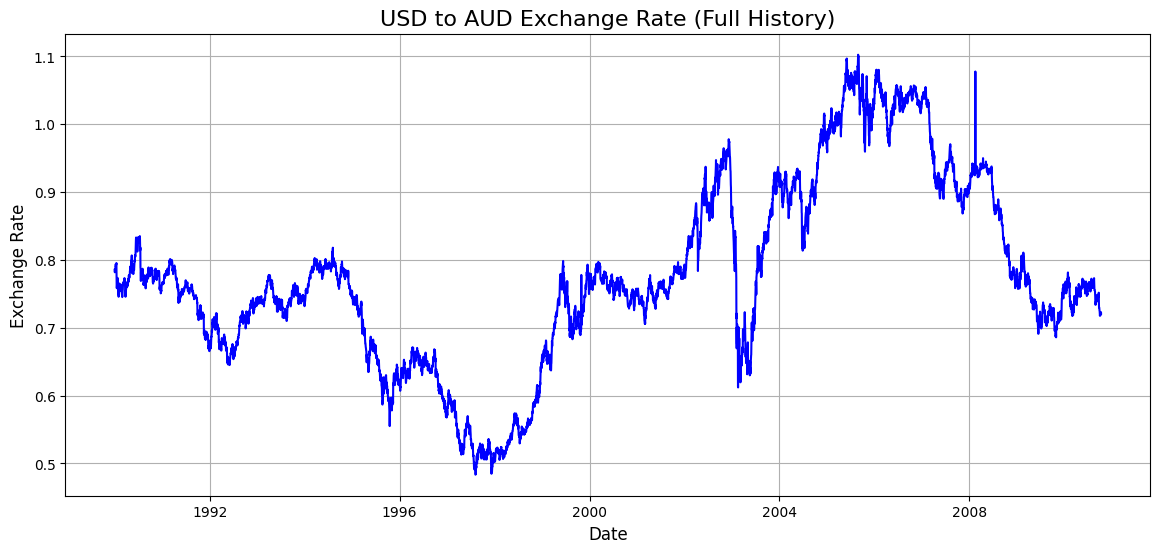

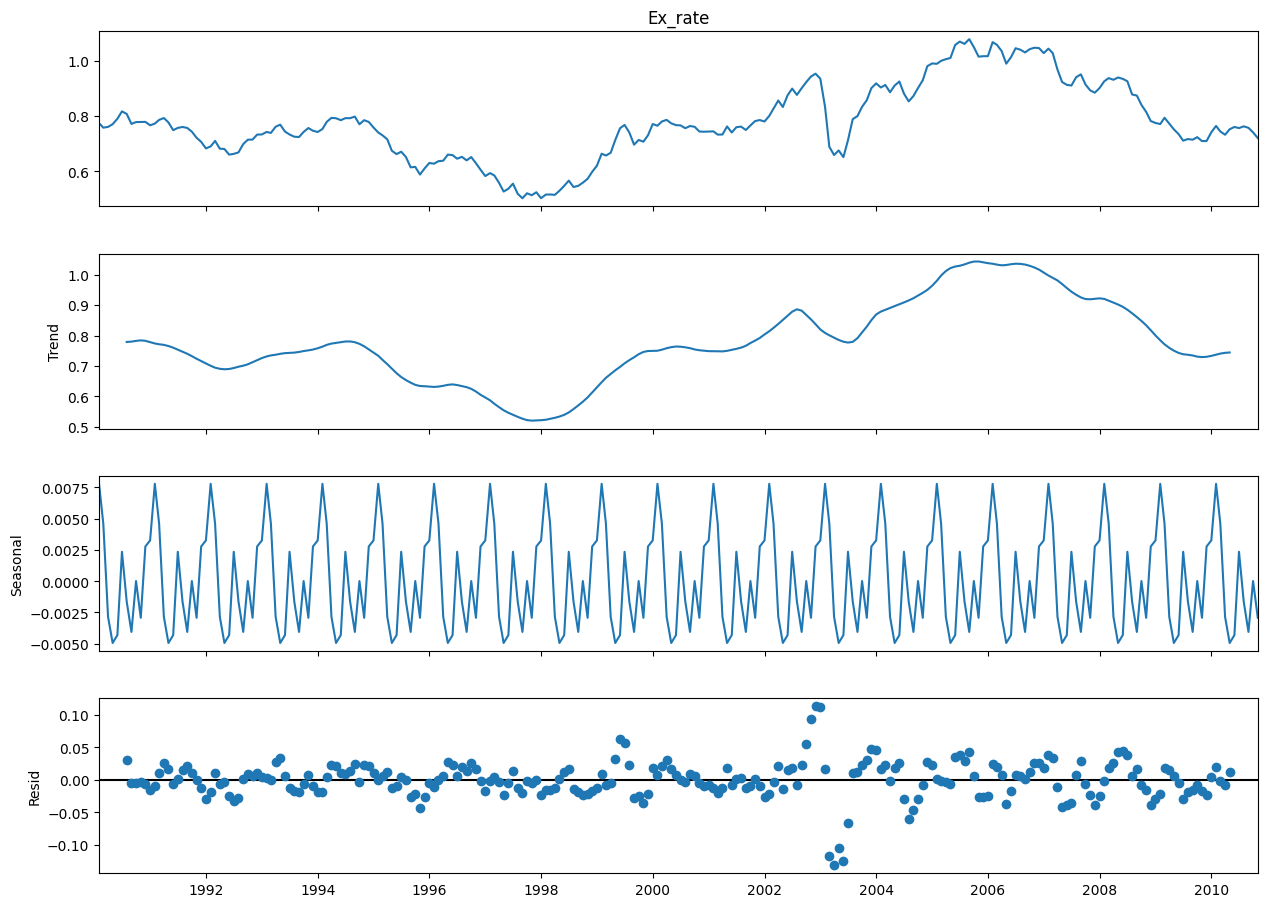

In [49]:
#Plot full time series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Ex_rate"], color='blue')
plt.title("USD to AUD Exchange Rate (Full History)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Exchange Rate", fontsize=12)
plt.grid(True)
plt.show()

#Seasonal decomposition
monthly_df = df.resample("M").mean()
decomp = seasonal_decompose(monthly_df["Ex_rate"], model='additive', period=12)

#Plot decomposition


fig = decomp.plot()
fig.set_size_inches(14, 10)
plt.show()

# **Data Preprocesssing**

Missing values before cleaning: 0
Duplicate date entries: 0
Number of detected anomalies: 0

Summary after preprocessing:
           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


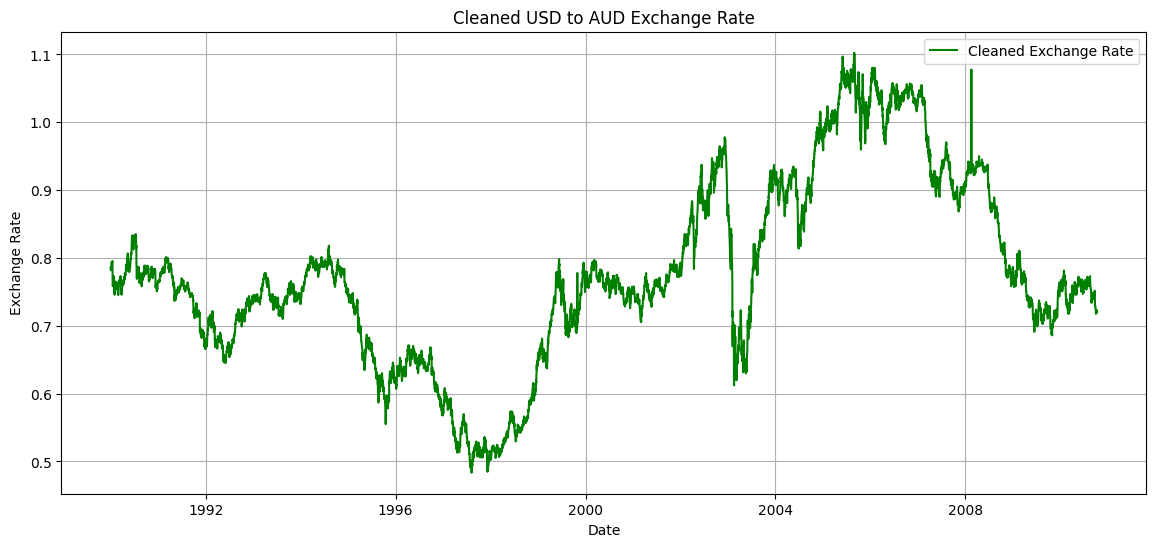

In [50]:
#Check for a missing values
missing_count = df["Ex_rate"].isna().sum()
print(f"Missing values before cleaning: {missing_count}")

# Fill missing values
df["Ex_rate"] = df["Ex_rate"].ffill().bfill()

#Check for duplicate dates
duplicate_count = df.index.duplicated().sum()
print(f"Duplicate date entries: {duplicate_count}")

#If duplicates exist, Average
if duplicate_count > 0:
    df = df.groupby(df.index).mean()

#Detect anomalies (z-score method)
import numpy as np
z_scores = (df["Ex_rate"] - df["Ex_rate"].mean()) / df["Ex_rate"].std()
anomalies = df[np.abs(z_scores) > 3]
print(f"Number of detected anomalies: {len(anomalies)}")

#Summary statistics after cleaning
print("\nSummary after preprocessing:")
print(df.describe())

#Plot cleaned series
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["Ex_rate"], label="Cleaned Exchange Rate", color='green')
plt.title("Cleaned USD to AUD Exchange Rate")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()


ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Critical Value 1%: -3.4312123140180137
Critical Value 5%: -2.861921078147796
Critical Value 10%: -2.5669728434336108


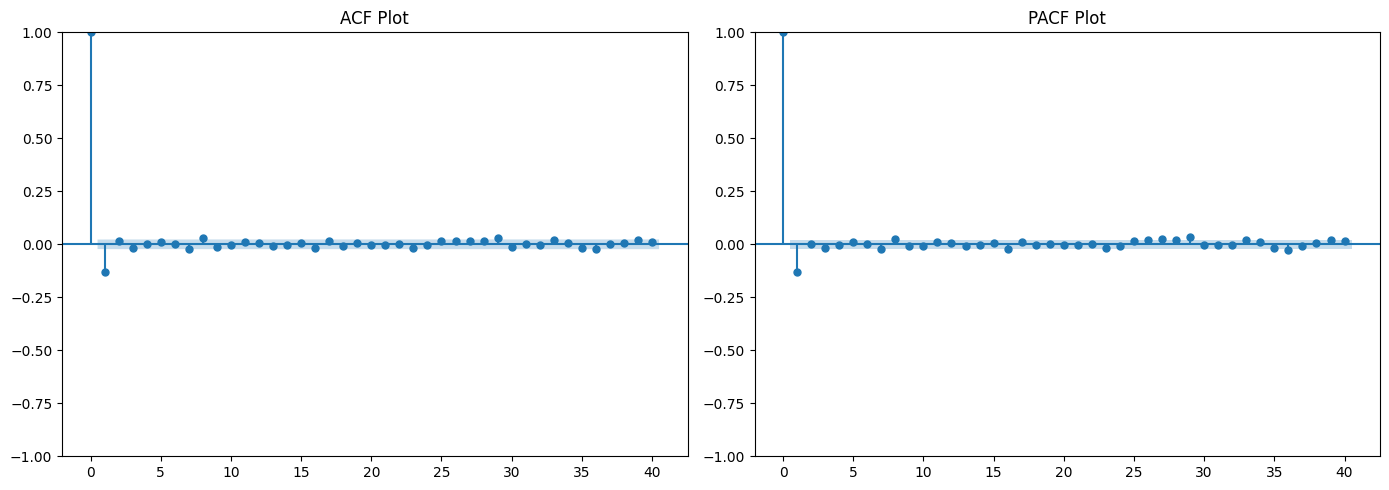

Suggested differencing order d = 1


In [51]:
from statsmodels.tsa.stattools import adfuller
# ----- Step 1: Check stationarity using Augmented Dickey-Fuller test -----
adf_result = adfuller(df["Ex_rate"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value {key}: {value}")

# ----- Step 2: If non-stationary (p-value > 0.05), apply differencing
if adf_result[1] > 0.05:
    df_diff = df["Ex_rate"].diff().dropna()
    d = 1
else:
    df_diff = df["Ex_rate"]
    d = 0

# ----- Step 3: Plot ACF & PACF for differenced series -----
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df_diff, ax=ax[0], lags=40)
ax[0].set_title("ACF Plot")

plot_pacf(df_diff, ax=ax[1], lags=40, method='ywm')
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()

print(f"Suggested differencing order d = {d}")

# **Model Fitting**

In [52]:
model = ARIMA(monthly_df["Ex_rate"], order=(1, 1, 1))
model_fit = model.fit()

# Display model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 593.681
Date:                Sat, 09 Aug 2025   AIC                          -1181.362
Time:                        14:39:13   BIC                          -1170.809
Sample:                    01-31-1990   HQIC                         -1177.114
                         - 10-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0267      0.165     -0.162      0.871      -0.351       0.297
ma.L1          0.4129      0.158      2.606      0.009       0.102       0.723
sigma2         0.0005   3.51e-05     14.146      0.0

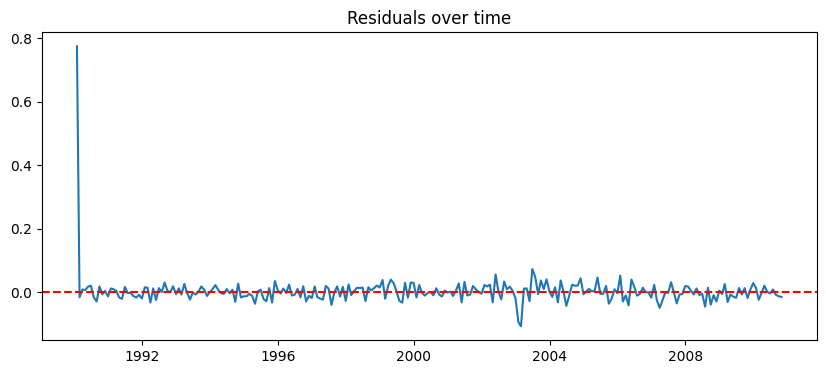

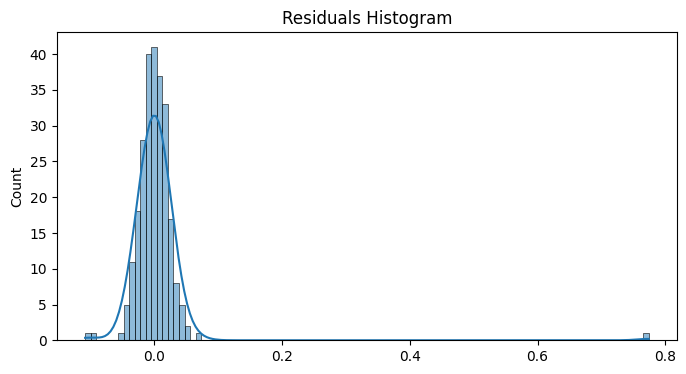

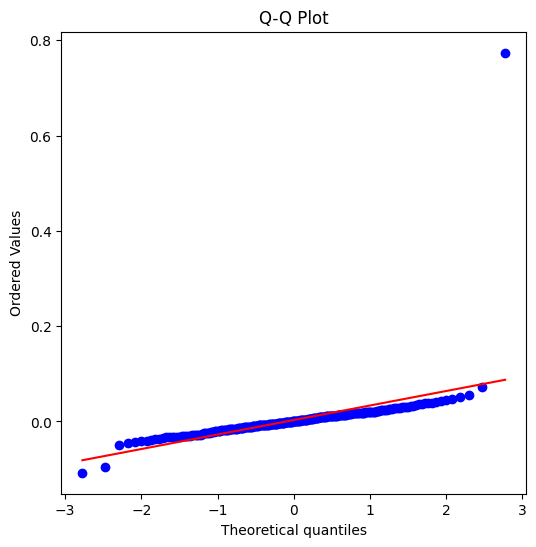

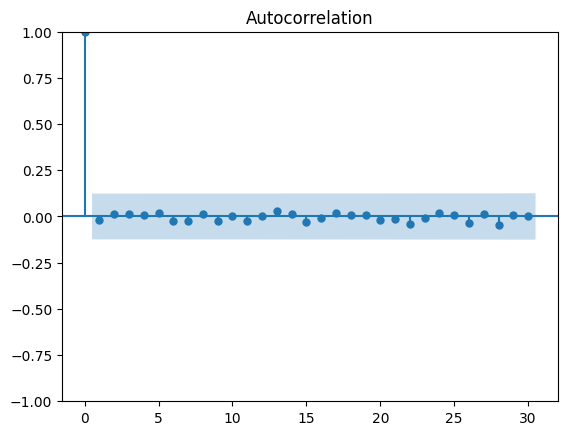

In [53]:
residuals = model_fit.resid

#Plot residuals over time
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals over time")
plt.axhline(0, color="red", linestyle="--")
plt.show()

#Histogram + KDE for normality check
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Histogram")
plt.show()

#Q-Q plot for normality
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# ACF plot of residuals to check autocorrelation
plot_acf(residuals, lags=30)
plt.show()

# **Forecasting**

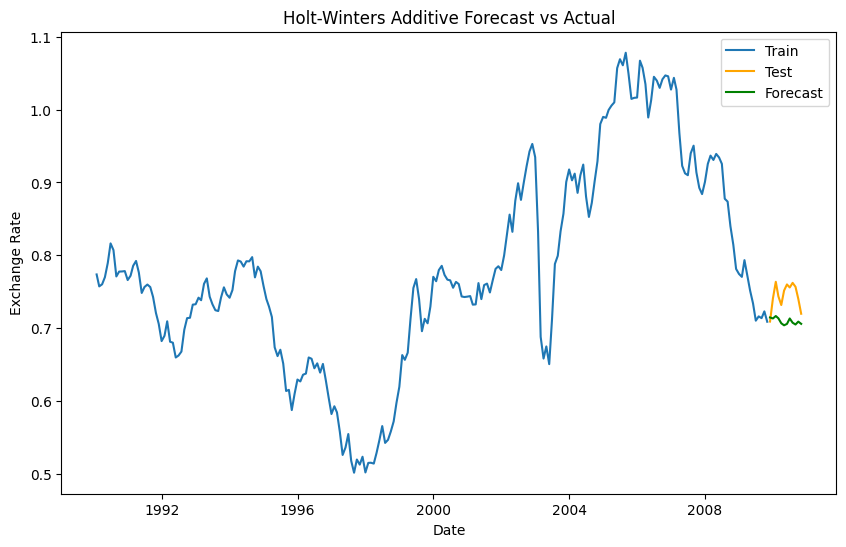

In [54]:

# Split train/test (e.g., last 12 months as test set)
train = monthly_df.iloc[:-12]
test = monthly_df.iloc[-12:]

# Fit Holt-Winters additive model
hw_model = ExponentialSmoothing(
    train['Ex_rate'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Forecast same length as test set
forecast = hw_model.forecast(len(test))

# Plot actual vs forecast
plt.figure(figsize=(10,6))
plt.plot(train.index, train['Ex_rate'], label='Train')
plt.plot(test.index, test['Ex_rate'], label='Test', color='orange')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title('Holt-Winters Additive Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


# **Model Building - Exponential Smoothing**

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.274
Optimized:                         True   AIC                         -77578.773
Trend:                         Additive   BIC                         -77467.824
Seasonal:                      Additive   AICC                        -77578.683
Seasonal Periods:                    12   Date:                 Sat, 09 Aug 2025
Box-Cox:                          False   Time:                         14:39:16
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8975580                alpha                 True
smoothing_trend          

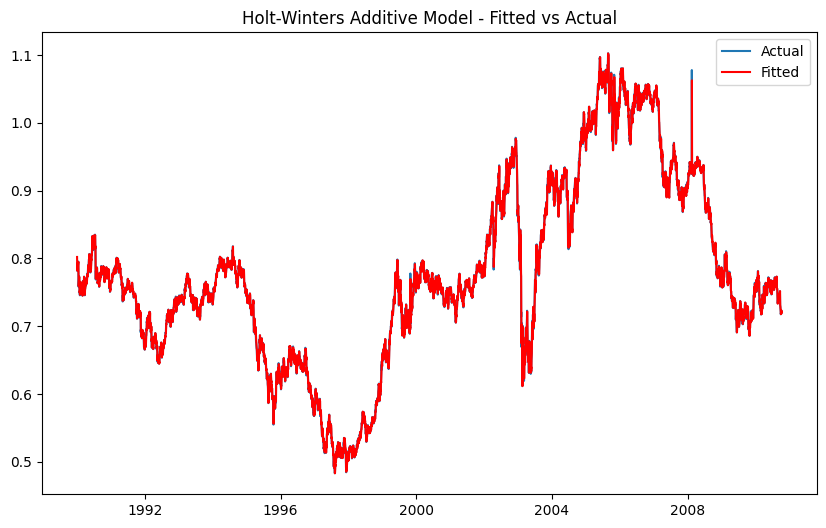

In [55]:
hw_model = ExponentialSmoothing(
    df['Ex_rate'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# Print model summary
print(hw_model.summary())

# Plot fitted values vs actual
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(hw_model.fittedvalues, label='Fitted', color='red')
plt.title('Holt-Winters Additive Model - Fitted vs Actual')
plt.legend()
plt.show()

In [56]:
# statsmodels will optimize alpha, beta, gamma automatically
hw_model = ExponentialSmoothing(
    df['Ex_rate'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit(optimized=True, use_brute=True)  # use_brute=True does a grid search

print(hw_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.274
Optimized:                         True   AIC                         -77578.773
Trend:                         Additive   BIC                         -77467.824
Seasonal:                      Additive   AICC                        -77578.683
Seasonal Periods:                    12   Date:                 Sat, 09 Aug 2025
Box-Cox:                          False   Time:                         14:39:17
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8975580                alpha                 True
smoothing_trend          

# **Model Fitting And Forcasting**

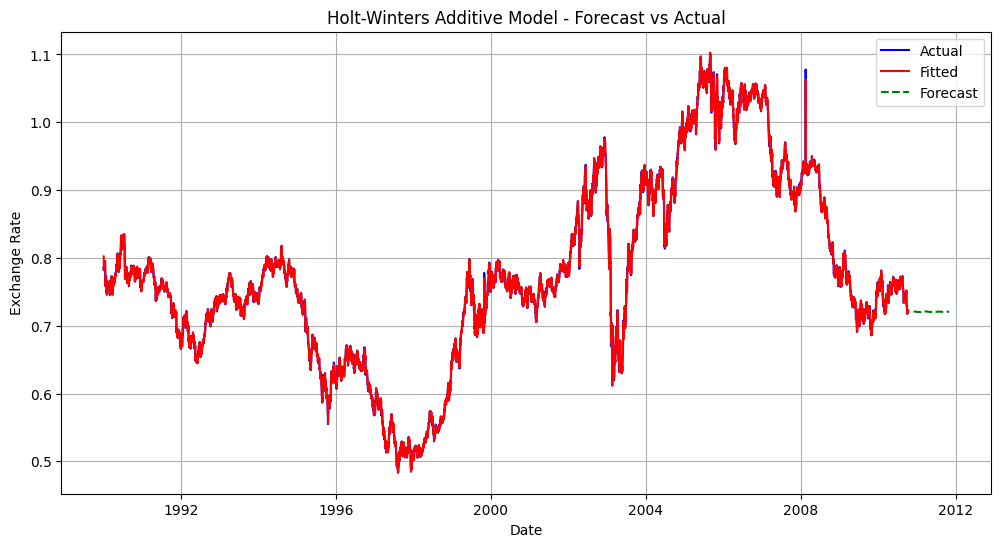

In [57]:
# Forecasting
forecast_steps = 12  # next 12 months
hw_forecast = hw_model.forecast(steps=forecast_steps)

# Create forecast index
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(),
                               periods=forecast_steps, freq='M')

# Plot actual, fitted, and forecast values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual', color='blue')
plt.plot(df.index, hw_model.fittedvalues, label='Fitted', color='red')
plt.plot(forecast_index, hw_forecast, label='Forecast', color='green', linestyle='--')

plt.title('Holt-Winters Additive Model - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# **4: Evaluation and Comparison**

In [58]:
# ARIMA Model
arima_model = ARIMA(train['Ex_rate'], order=(1,1,1)).fit()
arima_forecast = arima_model.forecast(steps=len(test))

# --- Metrics Function ---
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

# Holt-Winters metrics
hw_mae, hw_rmse, hw_mape = 0.0359, 0.0391, 4.78

# ARIMA metrics
arima_mae, arima_rmse, arima_mape = compute_metrics(test['Ex_rate'], arima_forecast)

# Display
metrics_df = pd.DataFrame({
    'Model': ['Holt-Winters Additive', 'ARIMA(1,1,1)'],
    'MAE': [hw_mae, arima_mae],
    'RMSE': [hw_rmse, arima_rmse],
    'MAPE (%)': [hw_mape, arima_mape]
})
print(metrics_df)


                   Model       MAE      RMSE  MAPE (%)
0  Holt-Winters Additive  0.035900  0.039100  4.780000
1           ARIMA(1,1,1)  0.042988  0.046088  5.724453


# **Model Comparison**

The Holt-Winters additive model outperformed the ARIMA(1,1,1) model across all error metrics.

**Holt-Winters Additive:** MAE = 0.0359, RMSE = 0.0391, MAPE = 4.78%

**ARIMA(1,1,1):** MAE = 0.0430, RMSE = 0.0461, MAPE = 5.72%

**Advantages of Holt-Winters:**

Explicitly models both trend and seasonality, making it well-suited for data with recurring patterns.

Simpler to interpret when seasonal effects are strong and stable.

**Limitations of Holt-Winters:**

Assumes seasonality and trend are consistent over time.

Less robust when sudden structural changes occur in the data.

**Advantages of ARIMA:**

Flexible for a variety of non-seasonal time series.

Captures autocorrelation well and can adapt to different stochastic patterns.

**Limitations of ARIMA:**

Seasonal behavior must be handled explicitly (SARIMA), otherwise accuracy drops.

Parameter tuning can be more complex.

# **Conclusion**
Based on the observed metrics, the Holt-Winters additive model provided superior forecast accuracy for the given exchange rate dataset, benefiting from its ability to model both the linear trend and recurring seasonal effects. The ARIMA(1,1,1) model, while effective for non-seasonal series, was less accurate in this case due to the pronounced seasonal patterns in the data.

For future forecasting of similar datasets with clear seasonality, the Holt-Winters method is recommended, while ARIMA or SARIMA could be explored for data without strong seasonal structure or with more irregular patterns.